# Causal Discovery exercise

The goal of this notebook is to demonstrate the complete workflow of causal discovery and causal inference. We'll begin by exploring three widely used causal discovery methods: PC, GES and LiNGAM. With the causal graphs generated from these methods, we'll then proceed to estimate some of the causal effects through linear regression.

## Import libraries

**Note:** There are several tools available for causal discovery and causal inference. In this notebook, we use `DoWhy` because it's a pure Python package. Other packages, e.g. `cdt`, might require external dependencies like R and specific R libraries installed to implement certain algorithms (e.g. PC or GES). For more details, please refer to the `causal_discovery_example.ipynb` notebook.

In [ ]:
import dowhy
from dowhy import CausalModel # enables dowhy to do causal discovery
import cdt # for glasso only

import numpy as np
import pandas as pd
import graphviz
import networkx as nx # for plotting graphs
from helper_functions import make_graph, str_to_dot # helper functions to draw the DAGs

np.set_printoptions(precision=3, suppress=True) # adjust precisions and avoid scentific notation
np.random.seed(0) # set seeds

In [25]:
# Check package versions
print(f"[INFO] Using dowhy version: {dowhy.__version__}")
print(f"[INFO] Using graphviz version: {graphviz.__version__}")
print(f"[INFO] Using networkx version: {nx.__version__}")

[INFO] Using dowhy version: 0.12
[INFO] Using graphviz version: 0.20.3
[INFO] Using networkx version: 3.3


## Load the data

We're going to use the UCI Auto-MPG dataset, which is commonly used for regression - predicting a car's miles per gallon (`mpg`) from its properties like `horsepower`, `acceleration` etc. For more details, see the [Auto-MPG description on UCI](https://archive.ics.uci.edu/dataset/9/auto+mpg).

> **Note:**
> 1. Reading the dataset documentation and understanding each variable gives you domain insights (e.g., higher horsepower typically reduces mpg), which can guide you when orienting edges in a causal graph.
>
> 2. We’ll drop three columns—`model_year`, `origin`, and `car_name`—because they’re categorical/textual. Including them would violate assumptions of methods like LiNGAM (which assumes linear relationships among numeric variables).



In [26]:
# Load the data
data_mpg = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original',
                   delim_whitespace=True, header=None,
                   names = ['mpg', 'cylinders', 'displacement',
                            'horsepower', 'weight', 'acceleration',
                            'model year', 'origin', 'car name'])
data_mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino


In [27]:
# Drop missing values
data_mpg.dropna(inplace=True)
# Drop categorical features
data_mpg.drop(['model year', 'origin', 'car name'], axis=1, inplace=True)
print(data_mpg.shape)
data_mpg.head()

(392, 6)


,mpg,cylinders,displacement,horsepower,weight,acceleration
0,18.0,8.0,307.0,130.0,3504.0,12.0
1,15.0,8.0,350.0,165.0,3693.0,11.5
2,18.0,8.0,318.0,150.0,3436.0,11.0
3,16.0,8.0,304.0,150.0,3433.0,12.0
4,17.0,8.0,302.0,140.0,3449.0,10.5


## Create skeleton graph using Graphical Lasso

Before diving into causal discovery, we'll first create a *skleton* graph using Graphical Lasso with `cdt.independence.graph.Glasso()`. Glasso is not a causal discovery method by itself, but it gives you a sparse network capturing conditional dependencies. Typically, you want to:
1. Fit glasso to your data
2. Pass that skeleton into causal discoveries methods (e.g. PC for orientation).

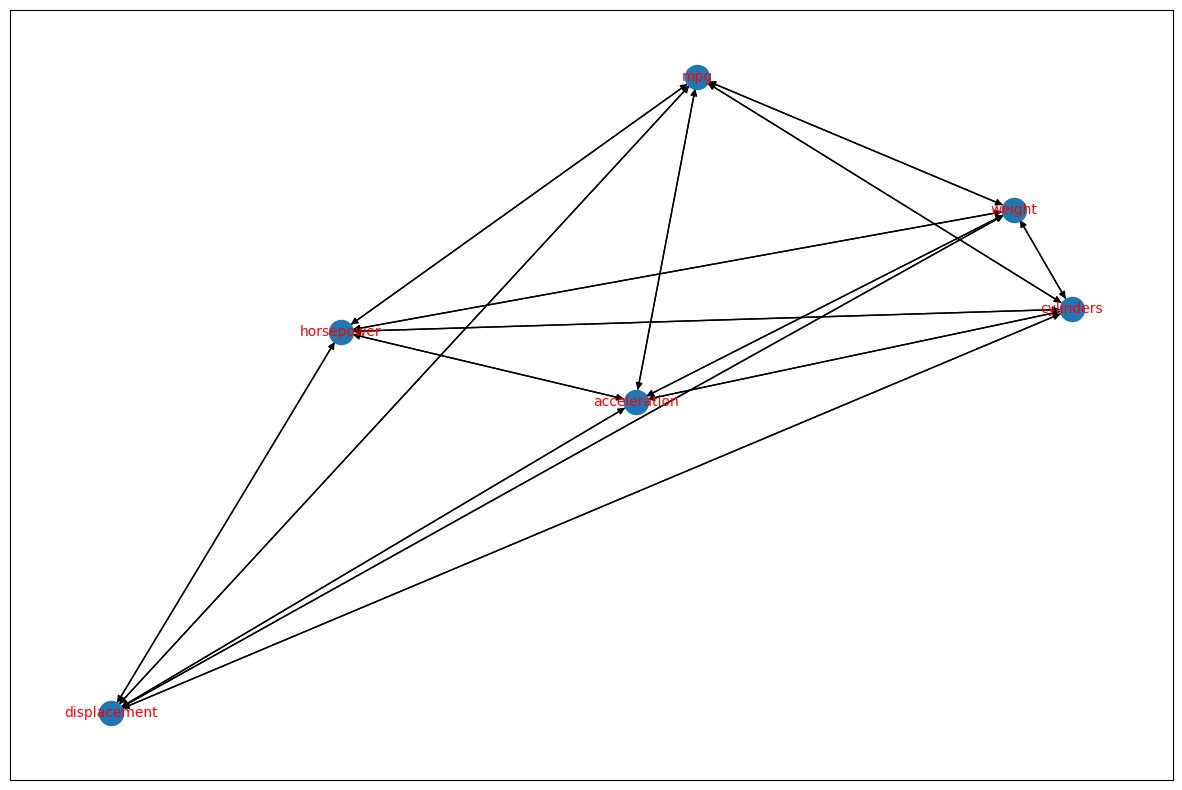

In [ ]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Initialise graph lasso
glasso = cdt.independence.graph.Glasso()

# Apply graph lasso to the dataset
skeleton = glasso.predict(data_mpg)

# Create layout with fixed seed
pos = nx.spring_layout(skeleton, seed=42)

# Remove self-loops
skeleton.remove_edges_from(nx.selfloop_edges(skeleton))

# Plot the graph
fig = plt.figure(figsize=(15, 10))
nx.draw_networkx(skeleton,
                 pos=pos,
                 font_size=10, 
                 font_color='r')

## 1. PC Algorithm

We'll implement the PC algorithm with the `causallearn` library.

**Note:** To render the resulting graph, you need both the Python wrapper **and** the `Graphviz` binaries installed.

If you're in a Conda environment, run these in your shell:
```bash
conda activate your-env-name
conda install -c conda-forge graphviz
```

Then you can verify the installation by:
```bash
dot -V # should print the graphviz version installed
```

Depth=3, working on node 5: 100%|██████████| 6/6 [00:00<00:00, 2729.78it/s]


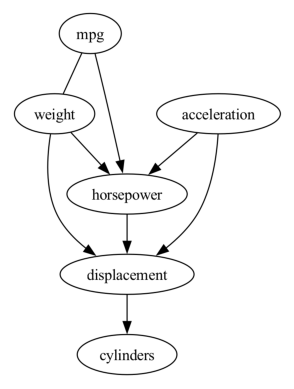

In [ ]:
from causallearn.search.ConstraintBased.PC import pc

labels = [f'{col}' for i, col in enumerate(data_mpg.columns)]
data = data_mpg.to_numpy()

# Run the pc algorithm
cg = pc(data)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(cg.G, labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

This is the causal graph discovered by PC. Next, let's try GES so we can compare their results.

## 2. GES

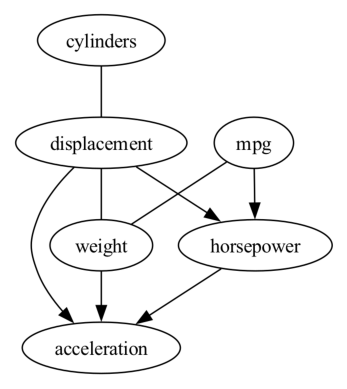

In [31]:
from causallearn.search.ScoreBased.GES import ges

# default parameters
Record = ges(data)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(Record['G'], labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

## Comparison of PC and GES results

### What's in common?
- Both PC and GES return a **CPDAG**. They both output the entire Markov-equivalence class rather than a fully directed DAG.
- Edges going into `mpg` - both of the results suggest no edges going into `mpg`, even though it was supposed to be a regression task trying to predict `mpg` by other features in the dataset.


### Differences
- Edge directions:
    
    - PC: 
        - `acceleration` -> `horsepower`/`displacement`: should be the other way round
        - `displacement` -> `cylinders`: should be the other way around, the number of cylinders should determine the size of an engine
        - `weight` -> `displacement`: should be the other way round, or they might share a common cause like `design`
    
    - GES:
        - `horsepower`/`displacement` -> `acceleration`: opposite to PC; more intuitive
        - `displacement` -> `horsepower` -> `acceleration`: this chain also makes sense
        - `weight` -> `accleration`: it makes sense intuitively; PC doesn't even suggest an edge between them

- Undirected edges:

    - PC:
        - `mpg` - `weight`: the only one undirected edge. We'd expect `weight` -> `mpg`, the heavier the car, the more fuel it'll probably need to consume to travel the same distance

    - GES:
        - `mpg` - `weight`: same as PC
        - `displacement` - `cylinders`: would expect `cylinders` -> `displacement`, the more the cylinders in the engine, the bigger the size of the engine
        - `displacement` - `weight`: same explanation as above

- Summary: PC seems to perform a bit worse than GES. As a constraint-based method, PC runs many conditional independence tests. With a small sample size (like this dataset), they lose statistical power and misidentify edges.


## 3. LiNGAM

The above two methods, PC and GES only return a CPDAG as an output. But for downstream tasks such as causal inference, we need a full DAG. This is where LiNGAM comes in handy:

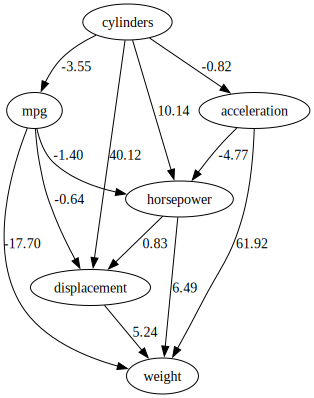

In [32]:
from causallearn.search.FCMBased import lingam
model = lingam.ICALiNGAM()
model.fit(data)

from causallearn.search.FCMBased.lingam.utils import make_dot
make_dot(model.adjacency_matrix_, labels=labels)

## Comparison between PC, GES and LiNGAM results:

Unlike PC and GES, LiNGAM gives you a **fully directed** causal graph with the estimated causal coefficients in one step. Now, let's take a look at some of the findings:

- `cylinders` -> `mpg` (-3.55): more cylinders consume more fuel, so mpg drops; the estimated effect also aligns with the logic
- Fork structure: `mpg` -> `weights` (-17.70) & `mpg` -> `horsepower` (-1.40): the directions should probably be flipped in reality, but the signs (both negative) both match reality. Both edges are undirected in PC/GES.
- Chain structure: `cylinders` -> `displacement` -> `weight`: it matches reality very well.
- Unintuitive lunks: `cylinders` -> `acceleration` (-0.82), `accerlation` -> `horsepower` (-4.77), `accerlation` -> `weight` (61.92, large effect but the direction should be flipped)

> **Note:** LiNGAM outputs a full DAG and also estimates the causal effect at the same time. But it has more strict assumptions:
>   1. Linear relationships between the parents and child
>   2. Non-Gaussian noise on each variable


## 4. Estimate causal effects using Linear Regression

Now we can estimate the causal effect of `mpg` on `weight` thanks to the DAG output by LiNGAM.

In [ ]:
import pygraphviz as pgv # if not insalled, you might need to downgrade pydot to a compatible version

# Obtain valid dot format
graph_dot = make_graph(model.adjacency_matrix_, labels=labels)

# Define Causal Model
model=CausalModel(
        data = data_mpg,
        treatment='mpg',
        outcome='weight',
        graph=str_to_dot(graph_dot.source))

# Identification
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

# Estimation
estimate = model.estimate_effect(identified_estimand,
                                method_name="backdoor.linear_regression",
                                control_value=0,
                                treatment_value=1,
                                confidence_intervals=True,
                                test_significance=True)
print("Causal Estimate is " + str(estimate.value))

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
──────(E[weight|cylinders])
d[mpg]                     
Estimand assumption 1, Unconfoundedness: If U→{mpg} and U→weight then P(weight|mpg,cylinders,U) = P(weight|mpg,cylinders)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

Causal Estimate is -38.940973656207916


## Interpretation

The estimated causal effect (ATE) is approx. -39. It can be interpeted as: an unit increase in `mpg` will cause approx. 39 lbs less weight.

Besides running a regression on the DAG, we can also get the total effect from LiNGAM by summing the path‐coefficients:

-17.7 + (-0.64 * 5.24) + (-1.4 * 0.83 * 5.24) + (-1.4 * 6.49) ≈ -36.22848, which is close to the result above.